In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json, sys, random, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import PIL
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import cv2
import matplotlib.pyplot as plt
from os import listdir
import time
import math
import shutil
from tqdm import tqdm
from tensorflow.keras.preprocessing import image

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

train = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/dataset/train',
    target_size=(400, 400),
    batch_size=32,
    class_mode='binary')

test = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/dataset/test',
    target_size=(400, 400),
    batch_size=32,
    class_mode='binary')

validation = val_datagen.flow_from_directory(
    '/content/drive/MyDrive/Colab Notebooks/dataset/valid',
    target_size=(400, 400),
    batch_size=32,
    class_mode='binary')

Found 2800 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Found 200 images belonging to 2 classes.


In [ ]:
print(train.class_indices)
print(test.class_indices)
print(validation.class_indices)

{'no': 0, 'yes': 1}
{}
{'no': 0, 'yes': 1}


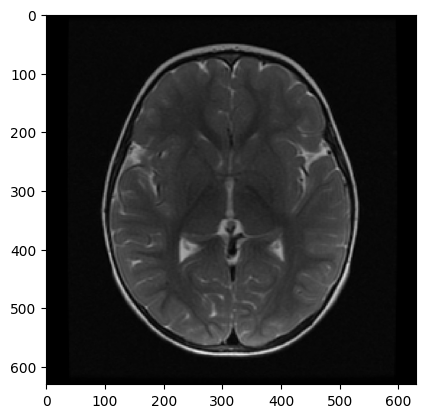

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/Colab Notebooks/dataset/test/N1.jpeg'))

In [ ]:
%pip install imutils

In [ ]:
IMG_SIZE = (224,224)
import imutils
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/dataset/test/N2.jpeg')
img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

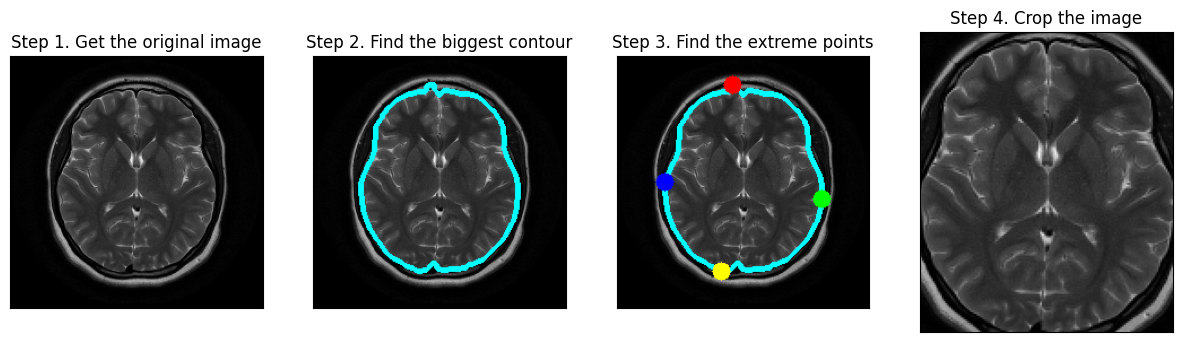

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [ ]:
es = EarlyStopping(monitor='val_accuracy', min_delta= 0.01 , patience= 5, verbose= 1, mode='auto')

In [ ]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size= (3,3), activation= 'relu', input_shape=(400, 400,3)) )

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu' ))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss= "binary_crossentropy", optimizer='adam', metrics=['accuracy'] )

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 398, 398, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 396, 396, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 198, 198, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 196, 196, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 98, 98, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 96, 96, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 294912)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │     150,995,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 151,130,849 (576.52 MB)

 Trainable params: 151,130,849 (576.52 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
es = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.01,
    patience=2,
    verbose=2,
    mode='auto'
)

# ModelCheckpoint callback (save best model with .keras extension)
mc = ModelCheckpoint(
    filepath='/content/drive/MyDrive/best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=2
)

In [ ]:
model.fit(
    x=train,  # Training data generator
    validation_data=validation,  # Validation data generator
    epochs=5,  # Number of epochs to train the model
    callbacks=[mc, es],  # List of callbacks (EarlyStopping and ModelCheckpoint)
    steps_per_epoch=50  # Number of steps to run per epoch, usually len(train) // batch_size
)



Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7959 - loss: 0.4263
Epoch 1: val_accuracy improved from 0.76000 to 0.78000, saving model to /content/drive/MyDrive/best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 109s 2s/step - accuracy: 0.7960 - loss: 0.4262 - val_accuracy: 0.7800 - val_loss: 0.4695
Epoch 2/5
38/50 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.8344 - loss: 0.3761
Epoch 2: val_accuracy did not improve from 0.78000
50/50 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.8327 - loss: 0.3808 - val_accuracy: 0.7550 - val_loss: 0.5357
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8627 - loss: 0.3241
Epoch 3: val_accuracy did not improve from 0.78000
50/50 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.8627 - loss: 0.3241 - val_accuracy: 0.7600 - val_loss: 0.5112
Epoch 3: early stopping


In [ ]:
pd.DataFrame(model.history.history)

accuracy      loss  val_accuracy  val_loss
0  0.803125  0.422256         0.780  0.469510
1  0.827500  0.395690         0.755  0.535684
2  0.865000  0.321364         0.760  0.511203

<Axes: >

<Figure size 1200x1000 with 0 Axes>

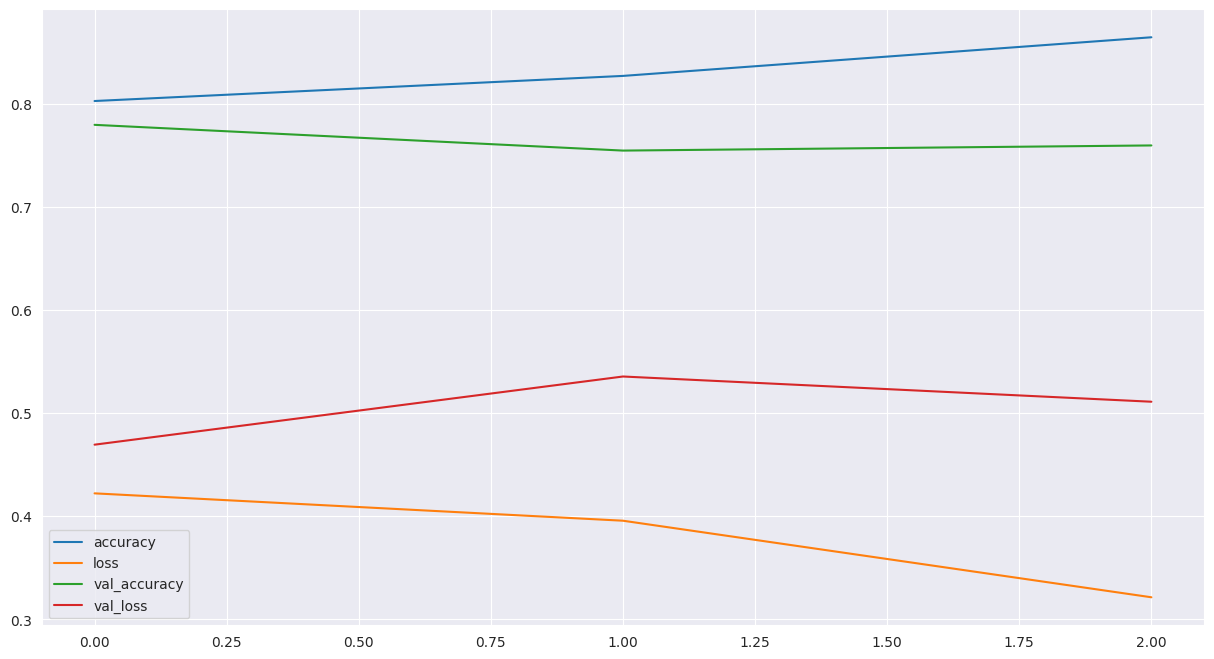

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
plt.figure(figsize=(12,10))
pd.DataFrame(model.history.history).plot(figsize=(15,8))

In [ ]:
def predictor(location):
    test_image=image.load_img(location,target_size=(400,400))
    test_image=image.img_to_array(test_image)
    test_image=np.expand_dims(test_image, axis=0)
    result=model.predict(test_image)

    if result[0][0] == 0:

        prediction = "The MRI image is no of BRAIN TUMOR"
    else:
        prediction = "The MRI image is of BRAIN TUMOR"
    print(result[0][0])
    return prediction

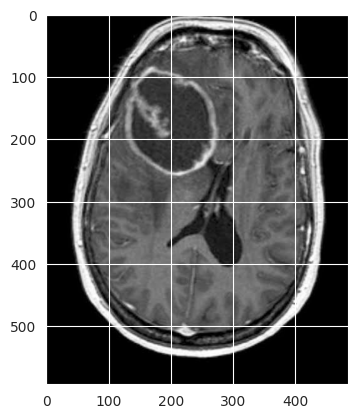

In [ ]:
plt.imshow(plt.imread('/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1400.jpg'))

In [ ]:
predictor('/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1400.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
7.9369894e-21


'The MRI image is of BRAIN TUMOR'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
0.0


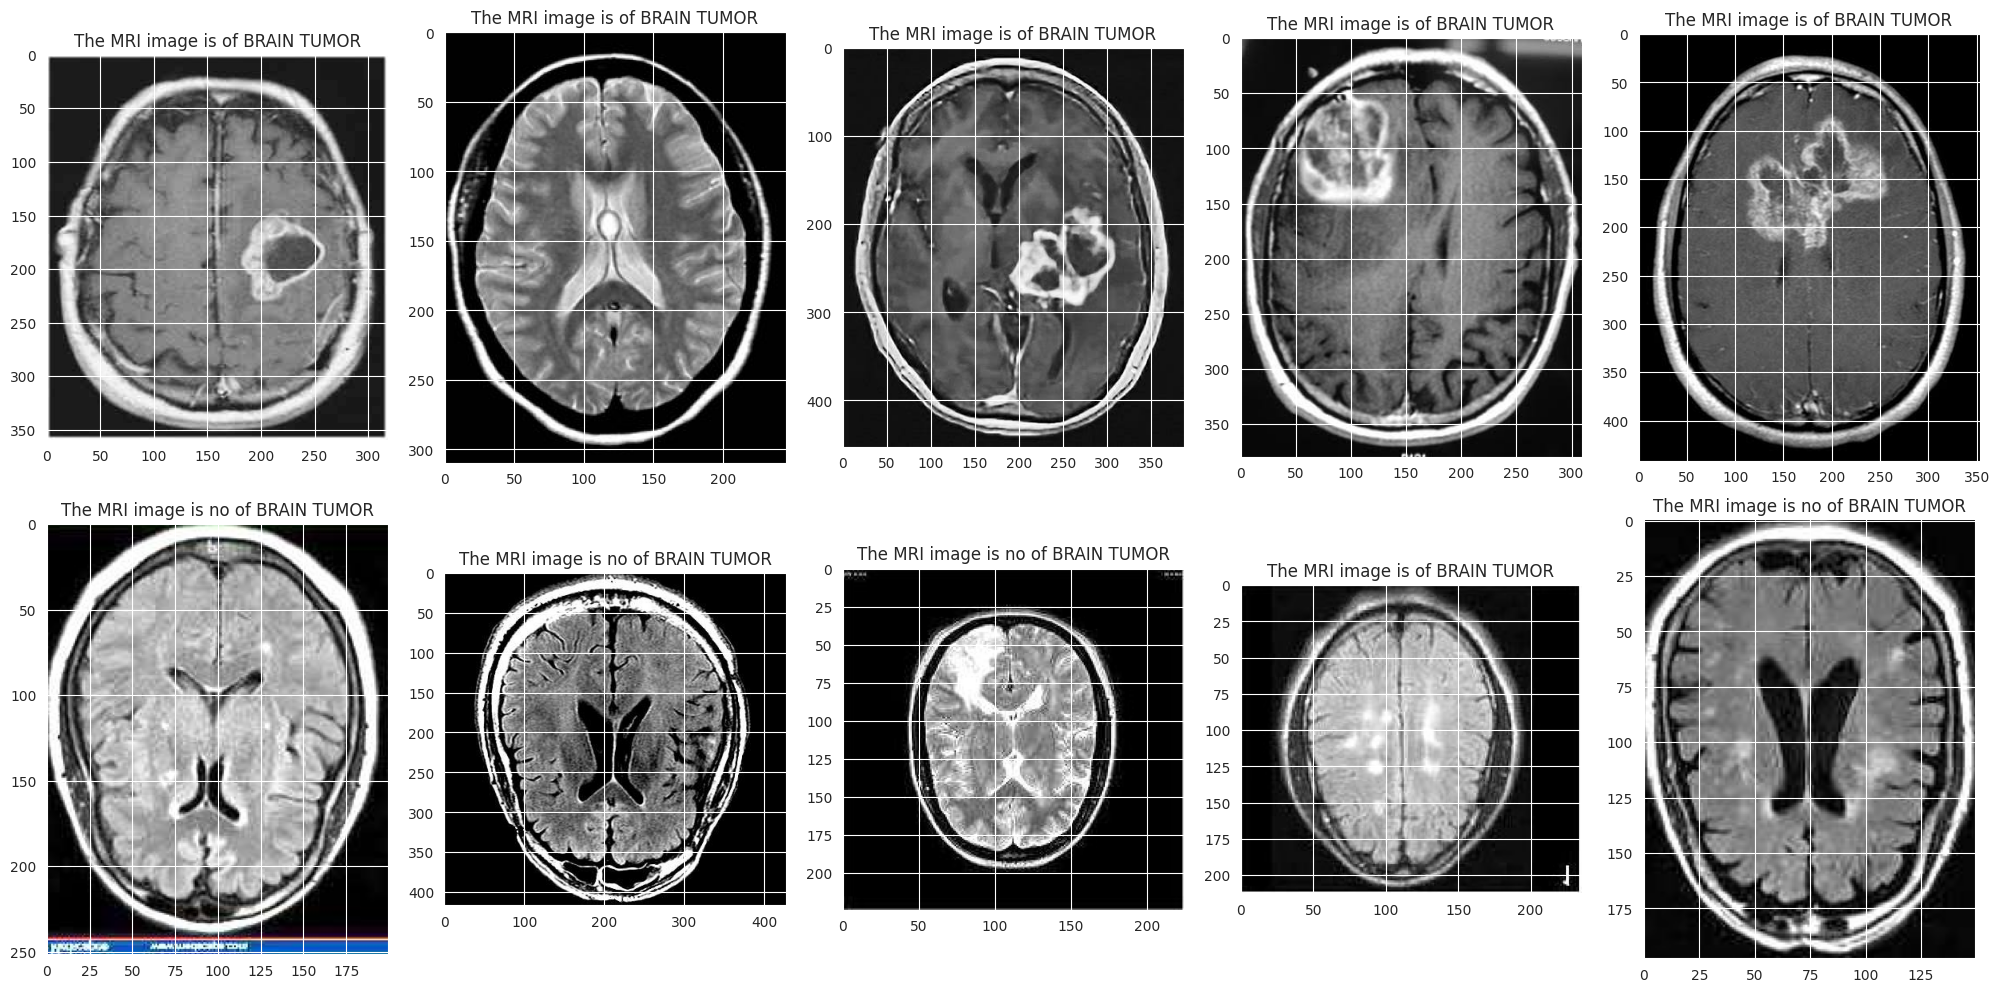

In [ ]:
import PIL
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
lst = ['/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1401.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1402.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1403.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1404.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1405.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1400.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1401.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1402.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1403.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1404.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1405.jpg']

axs[0][0].title.set_text(predictor(lst[0]))
axs[0][0].imshow(PIL.Image.open(lst[0]))
axs[0][1].title.set_text(predictor(lst[1]))
axs[0][1].imshow(PIL.Image.open(lst[1]))
axs[0][2].title.set_text(predictor(lst[2]))
axs[0][2].imshow(PIL.Image.open(lst[2]))
axs[0][3].title.set_text(predictor(lst[3]))
axs[0][3].imshow(PIL.Image.open(lst[3]))
axs[0][4].title.set_text(predictor(lst[4]))
axs[0][4].imshow(PIL.Image.open(lst[4]))
axs[1][0].title.set_text(predictor(lst[5]))
axs[1][0].imshow(PIL.Image.open(lst[5]))
axs[1][1].title.set_text(predictor(lst[6]))
axs[1][1].imshow(PIL.Image.open(lst[6]))
axs[1][2].title.set_text(predictor(lst[7]))
axs[1][2].imshow(PIL.Image.open(lst[7]))
axs[1][3].title.set_text(predictor(lst[8]))
axs[1][3].imshow(PIL.Image.open(lst[8]))
axs[1][4].title.set_text(predictor(lst[9]))
axs[1][4].imshow(PIL.Image.open(lst[9]))

fig.tight_layout()

In [ ]:
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [ ]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)
train = train_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/dataset/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')
test = test_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/dataset/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')
validation = val_datagen.flow_from_directory(
        '/content/drive/MyDrive/Colab Notebooks/dataset/valid',
        target_size=(224, 224),
        batch_size=32,
        class_mode='binary')

Found 2800 images belonging to 2 classes.
Found 0 images belonging to 0 classes.
Found 200 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
base_model = MobileNet(input_shape=(224, 224, 3),#we can specify the inpur shape with this parameter
    include_top=False) # Do not include the ImageNet classifier at the top.)

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.trainable = False # We freeze the training of the convolutions
base_model.summary()

Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
# Flatten the output layer to 1 dimension
cnn = Flatten()(base_model.output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
cnn = Dense(units=1024, activation ="relu")(cnn)
# Add a dropout rate of 0.2
cnn = Dropout(0.2)(cnn)
# Add a final sigmoid layer for classification
cnn = Dense(units = 1, activation = "sigmoid")(cnn)
cnn = Model( base_model.input, cnn)

In [ ]:
cnn.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1 (Conv2D)                       │ (None, 112, 112, 32)        │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_bn (BatchNormalization)        │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1_relu (ReLU)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1 (DepthwiseConv2D)          │ (None, 112, 112, 32)        │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_bn (BatchNormalization)    │ (None, 112, 112, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_1_relu (ReLU)                │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1 (Conv2D)                   │ (None, 112, 112, 64)        │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_bn (BatchNormalization)    │ (None, 112, 112, 64)        │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_1_relu (ReLU)                │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pad_2 (ZeroPadding2D)           │ (None, 113, 113, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2 (DepthwiseConv2D)          │ (None, 56, 56, 64)          │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_bn (BatchNormalization)    │ (None, 56, 56, 64)          │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_2_relu (ReLU)                │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2 (Conv2D)                   │ (None, 56, 56, 128)         │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_2_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3 (DepthwiseConv2D)          │ (None, 56, 56, 128)         │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_bn (BatchNormalization)    │ (None, 56, 56, 128)         │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_dw_3_relu (ReLU)                │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_pw_3 (Conv2D)                   │ (None, 56, 56, 128)         │          16,384 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 54,611,137 (208.32 MB)

 Trainable params: 51,382,273 (196.01 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [ ]:
cnn.compile(optimizer = RMSprop(learning_rate=0.0001),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
es = EarlyStopping(monitor='val_accuracy', min_delta=0.01, patience=2, verbose=2, mode='auto')
mc = ModelCheckpoint(filepath='/content/drive/MyDrive/Colab Notebooks/best_modelwithtransferlearning.keras',
                     monitor='val_accuracy', save_best_only=True)

# Train the model
cnn.fit(
    x=train,  # Training data generator
    validation_data=validation,  # Validation data generator
    epochs=5,  # Number of epochs to train the model
    callbacks=[mc, es],  # List of callbacks (EarlyStopping and ModelCheckpoint)
    steps_per_epoch=50  # Number of steps per epoch (adjust based on your data)
)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 741ms/step - accuracy: 0.7362 - loss: 4.8046 - val_accuracy: 0.9300 - val_loss: 0.2294
Epoch 2/5
38/50 ━━━━━━━━━━━━━━━━━━━━ 6s 518ms/step - accuracy: 0.9105 - loss: 0.2640

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 412ms/step - accuracy: 0.9095 - loss: 0.2697 - val_accuracy: 0.8950 - val_loss: 0.3144
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 528ms/step - accuracy: 0.9261 - loss: 0.1791 - val_accuracy: 0.8550 - val_loss: 0.7686
Epoch 3: early stopping


In [ ]:
print(cnn.evaluate(validation))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - accuracy: 0.8404 - loss: 0.8418
[0.768571138381958, 0.8550000190734863]


In [ ]:
from tensorflow.keras.models import load_model

model_best = load_model("/content/drive/MyDrive/Colab Notebooks/best_modelwithtransferlearning.keras")


In [ ]:
model_best.evaluate(validation)

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 277ms/step - accuracy: 0.9295 - loss: 0.2642


[0.22940224409103394, 0.9300000071525574]

In [ ]:
validation.class_indices

{'no': 0, 'yes': 1}

In [ ]:
def predictor(path):
    img = image.load_img(path, target_size=(400,400),  )
    i = image.img_to_array(img)/255
    input_arr = np.array([i])
    input_arr.shape
    pred = model.predict(input_arr)[0][0]
    if pred > 0.5:
        print("The MRI image is of BRAIN TUMOR")
    else:
        print("The MRI image is of HEALTHY BRAIN WITHOUT TUMOR")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The MRI image is of BRAIN TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The MRI image is of BRAIN TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The MRI image is of BRAIN TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The MRI image is of BRAIN TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The MRI image is of BRAIN TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The MRI image is of HEALTHY BRAIN WITHOUT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The MRI image is of HEALTHY BRAIN WITHOUT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The MRI image is of HEALTHY BRAIN WITHOUT TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The MRI image is of BRAIN TUMOR
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
The MRI image is of HEALTHY BRAIN WITHOUT TUMOR


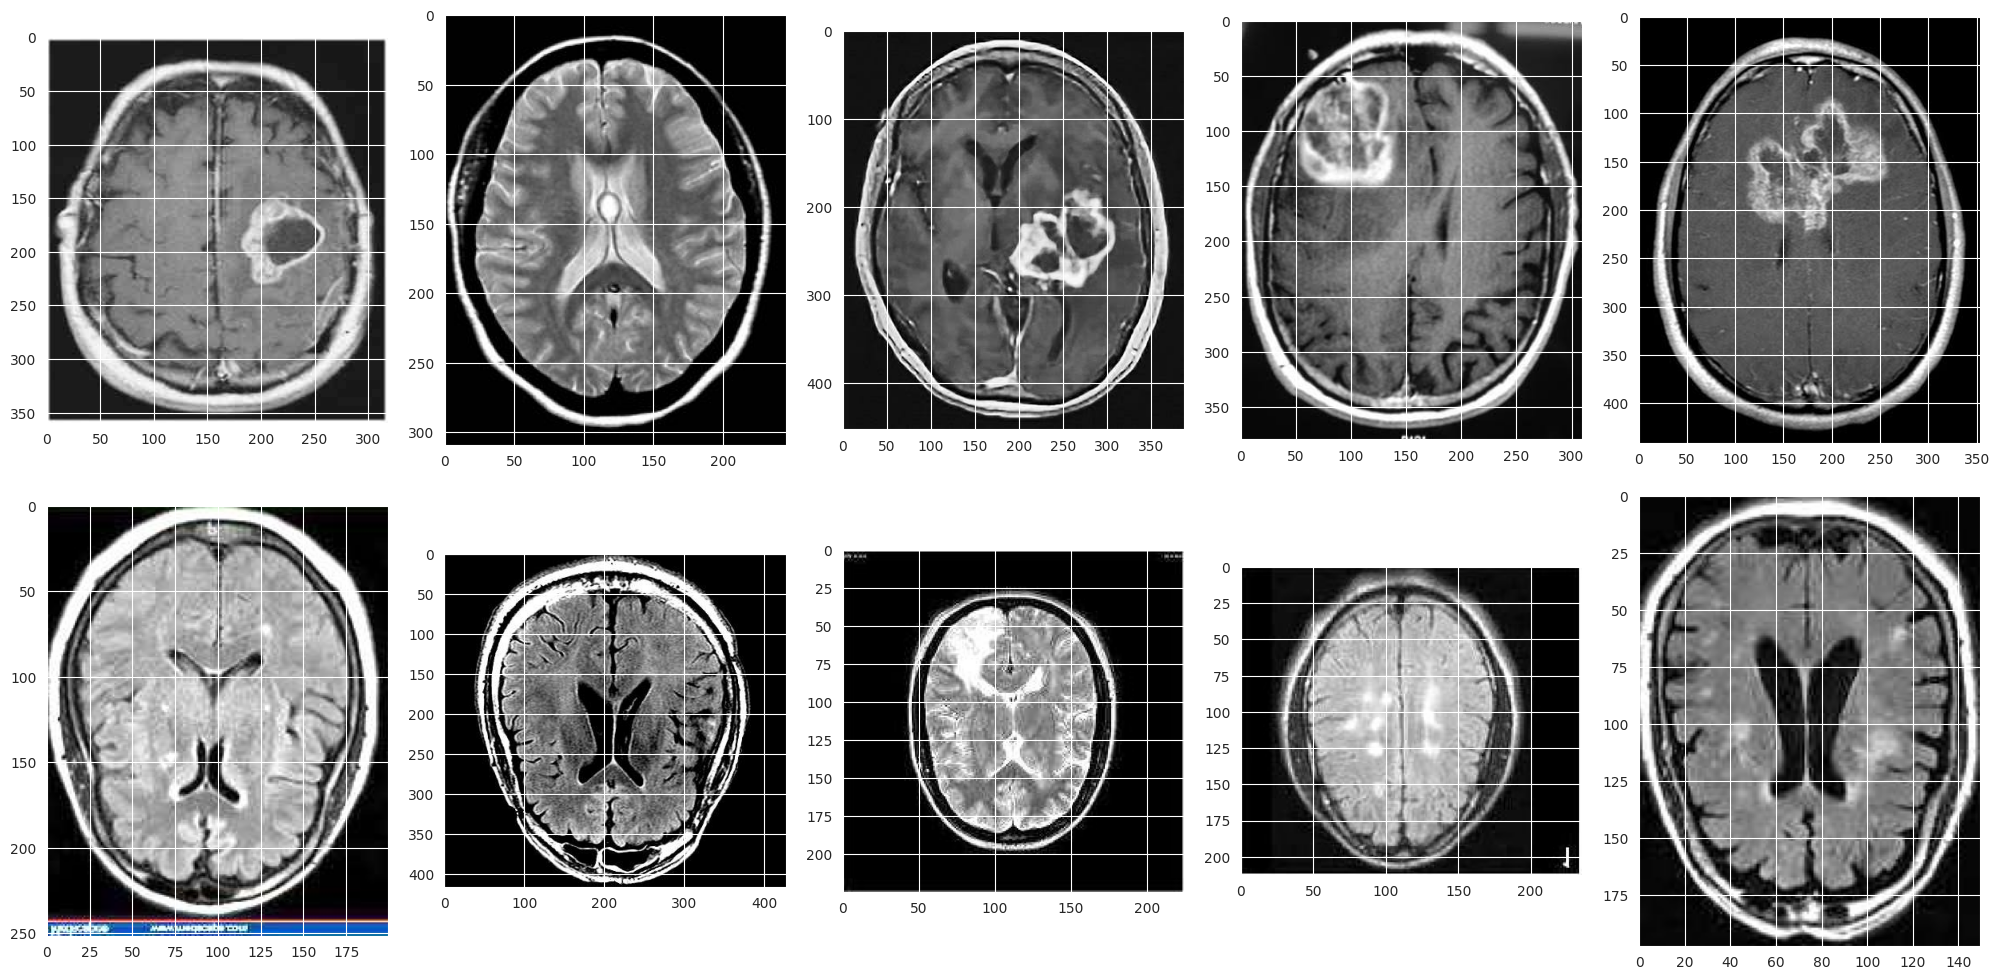

In [ ]:
import PIL
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
lst = ['/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1401.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1402.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1403.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1404.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1405.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1400.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1401.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1402.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1403.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1404.jpg',
       '/content/drive/MyDrive/Colab Notebooks/dataset/valid/no/no1405.jpg']

axs[0][0].title.set_text(predictor(lst[0]))
axs[0][0].imshow(PIL.Image.open(lst[0]))
axs[0][1].title.set_text(predictor(lst[1]))
axs[0][1].imshow(PIL.Image.open(lst[1]))
axs[0][2].title.set_text(predictor(lst[2]))
axs[0][2].imshow(PIL.Image.open(lst[2]))
axs[0][3].title.set_text(predictor(lst[3]))
axs[0][3].imshow(PIL.Image.open(lst[3]))
axs[0][4].title.set_text(predictor(lst[4]))
axs[0][4].imshow(PIL.Image.open(lst[4]))
axs[1][0].title.set_text(predictor(lst[5]))
axs[1][0].imshow(PIL.Image.open(lst[5]))
axs[1][1].title.set_text(predictor(lst[6]))
axs[1][1].imshow(PIL.Image.open(lst[6]))
axs[1][2].title.set_text(predictor(lst[7]))
axs[1][2].imshow(PIL.Image.open(lst[7]))
axs[1][3].title.set_text(predictor(lst[8]))
axs[1][3].imshow(PIL.Image.open(lst[8]))
axs[1][4].title.set_text(predictor(lst[9]))
axs[1][4].imshow(PIL.Image.open(lst[9]))

fig.tight_layout()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step


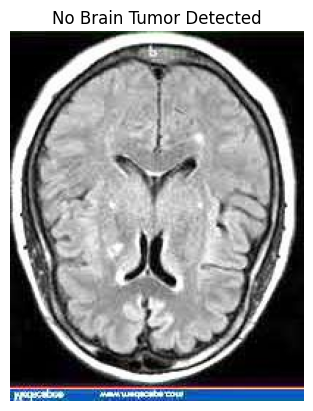

In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Load the trained model
model = tf.keras.models.load_model("/content/drive/MyDrive/best_model.keras")

def preprocess_image(img_path, target_size):
    """
    Preprocess the image for model prediction
    """
    # Load the image with the target size
    img = image.load_img(img_path, target_size=target_size)
    # Convert the image to an array
    img_array = image.img_to_array(img)
    # Normalize the image to [0, 1]
    img_array = img_array / 255.0
    # Expand dimensions to match the input shape (batch size, height, width, channels)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

def predict_image(img_path):
    """
    Predict whether the uploaded image indicates a brain tumor or not
    """
    # Define the target size for the model
    target_size = (400, 400)  # Model expects 400x400 images
    # Preprocess the image
    img_array = preprocess_image(img_path, target_size)

    # Make a prediction
    prediction = model.predict(img_array)

    # Interpret the result
    result = "Brain Tumor Detected" if prediction[0][0] > 0.5 else "No Brain Tumor Detected"

    # Display the image
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis('off')
    plt.title(result)
    plt.show()

# Specify the image path
img_path = "/content/drive/MyDrive/Colab Notebooks/dataset/valid/yes/y1402.jpg"

# Predict the result for the specified image
predict_image(img_path)
